<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом-(upsampling)" data-toc-modified-id="Борьба-с-дисбалансом-(upsampling)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом (upsampling)</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Задача: построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке.

Дополнительно измерить *AUC-ROC*, сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd

from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from joblib import dump

Для начала давайте посмотрим на данные: какие признаки доминируют, категориальные или числовые, построим гистограммы, чтобы посмотреть распределение, а также проверим целевой признак на сбалансированность.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
pd.read_csv('/datasets/Churn.csv')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


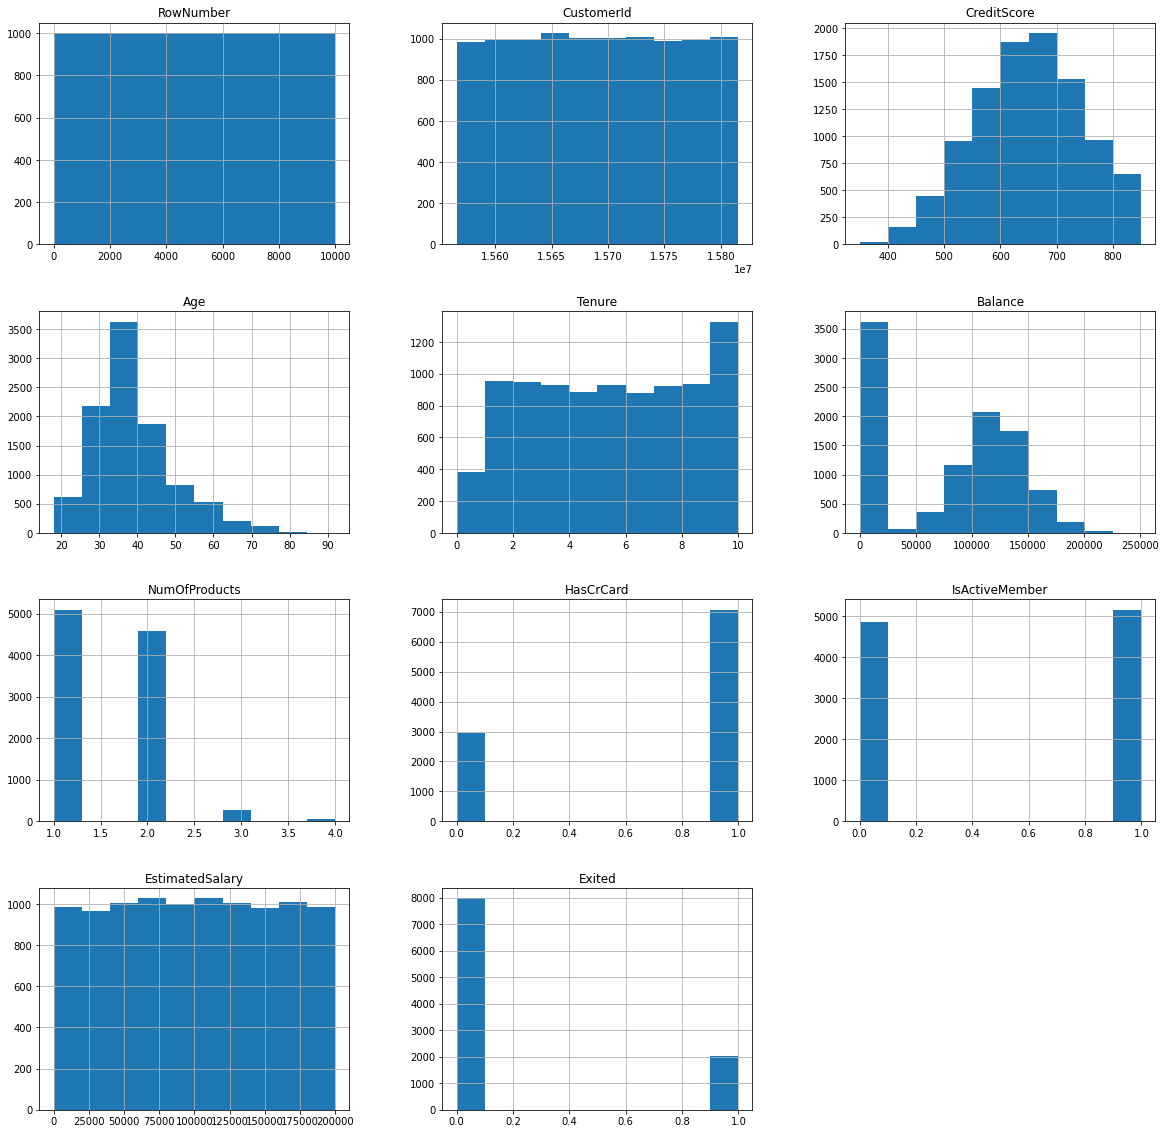

In [4]:
data.hist(figsize=(20, 20));

In [5]:
data.columns = data.columns.str.lower()

In [6]:
print(data['exited'].value_counts())

0    7963
1    2037
Name: exited, dtype: int64


В ходе знакомтва с данными, мы сразу привели названия всех колонок к нижнему регистру, чтобы было проще с ними разотать. Сразу хочу обратить внимание, что первые 3 колонки мало как повлияют на результат, но удалять их не будем, потому что данные будут подаваться в таком виде. Учитывая наличие таких признаков, как фамилия, порядковый номер, и id, я думаю, что лучше подойдет модель DT или RF, тк я не хотел бы,чтобы эти показателт хоть как-то были включены в уравнение регресии. 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
data = data.drop({'rownumber', 'customerid', 'surname'}, axis=1)

Это привет из будущего. С целью борьбы с переобучением было принято решение избавиться от данных 3 колонок, которые информативны для нас, но, вероятнее всего, оказывают негативное влияние на нашу модель. (Гипотеза подтвердилась)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [10]:
print(data['tenure'].value_counts())

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64


In [11]:
#print(data[data['tenure'].isna()])
display(data[data['tenure'].isna()])

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Неплохая новость - пропуски есть только в колонке tenure, в которой отображается, сколько лет человек является клиентом банка. У нас есть 909 пропусков. Исходя из графика и таблицы по данному признаку, в каждом году примерно одинаково клиентов, однако на нулевом году - количество клиентов сильно отстает. Я считаю, что скорее всего NaN в этой колонке означает 0, тогда и график станет логичней и не придется избавляться от 10% данных. Ели модель будет недостаточно хорошо справляться, мы подумаем о то, чтобы избавиться от данных вместо замены на 0. 

In [12]:
data['tenure']=data['tenure'].fillna(value=0)

In [13]:
print(data['tenure'].value_counts())

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64


Нулей стало больше всего, но не настолько, чтобы их количество казалось слишком завышенным. Теперь давайте произведем порядковое кодирование чтобы закодировать категоии цифрами. Нам это необходимо, чтобы стороить модели Дерева Решений и Случайного Леса.

In [14]:
encoder = OrdinalEncoder()
encoder.fit(data)
data_ordinal = encoder.transform(data)
data_ordinal = pd.DataFrame(encoder.transform(data), columns=data.columns) 

In [15]:
print(data_ordinal.head())

   creditscore  geography  gender   age  tenure  balance  numofproducts  \
0        228.0        0.0     0.0  24.0     2.0      0.0            0.0   
1        217.0        2.0     0.0  23.0     1.0    743.0            0.0   
2        111.0        0.0     0.0  24.0     8.0   5793.0            2.0   
3        308.0        0.0     0.0  21.0     1.0      0.0            1.0   
4        459.0        2.0     0.0  25.0     2.0   3696.0            0.0   

   hascrcard  isactivemember  estimatedsalary  exited  
0        1.0             1.0           5068.0     1.0  
1        0.0             1.0           5639.0     0.0  
2        1.0             0.0           5707.0     1.0  
3        0.0             0.0           4704.0     0.0  
4        1.0             1.0           3925.0     0.0  


Теперь давайте определим для модели целевой признак и признаки. Затем разобьем датафрейм на тренировочную, валидационную и тестовую выборки.

In [16]:
target = data_ordinal['exited']
features = data_ordinal.drop('exited', axis=1)

In [17]:
features_learn, features_test, target_learn, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1985, stratify=target)

In [18]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=1985,stratify=target)

Теперь, когда данные готовы, можем приступить к построению и тестированию моделей. 

## Исследование задачи

Начнем с дерева решений, оно проще, быстрее и позволит нам оценить ситуацию.

In [19]:
model = DecisionTreeClassifier(random_state=1985)
model.fit(features_train, target_train)

DecisionTreeClassifier(random_state=1985)

In [20]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 13):
    model = DecisionTreeClassifier(random_state=1985, max_depth=depth) 
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print(best_result, best_depth)

0.5862068965517241 5


F1 нашего дерева относительно близка к требуемой, но все же не дотягивает. 

Дерево решений не оправдало ожиданий заказчика, но у нас еще есть Случайный лес. Однако прежде чем начать строить новую модель, давайте посмотрим на полноту, точность и другие метрики в совокупности, чтобы понять, где наше дерево больше всего ошибается.

In [21]:
print(classification_report(target_valid, best_model.predict(features_valid), target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1991
           1       0.79      0.47      0.59       509

    accuracy                           0.87      2500
   macro avg       0.83      0.72      0.75      2500
weighted avg       0.86      0.87      0.85      2500



Из отчета мы видим, что наша модель хуже распозанет единицу. Особенно страдает полноста (модель чаще выбирает 0, чем единицу). А ведь по сути это ее главная задача - прогнозировать, какие клиенты могут уйти, чтобы банк мог предпринять меры. Причиной неудачи может быть низкое качество модели и недостаточное количество объектов с целевым показателем "1", еще одной из возможных причн может являться дисбаланс классов. Все это мы со временем выясним. 

 Теперь мы перейдем к созданию Случайного леса. Для подбора оптимальных гиперпараметров модели мы используем функцию GridSearchCV.

rfc = RandomForestClassifier(random_state=1985)
parameters = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,13, 1) }

%%time
grid = GridSearchCV(rfc, parameters, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

Мы получили лучшие параметры: глубина = 12 и количество деревьев = 40. Теперь обучим модель случайного леса и протестируем на валидационной выборке. 

In [22]:
%%time
best_model_rf = None
best_result_rf = 0
est = 0
depth_rf = 0
for est in range(10, 51, 5):
    for depth in range(1,13):
        clf = RandomForestClassifier(random_state=1985, n_estimators=est, max_depth=depth)
        clf.fit(features_train, target_train)
        result = clf.score(features_valid, target_valid)
        if result > best_result_rf:
            best_model_rf = clf
            best_result_rf = result
            est = est
            depth_rf = depth
print(best_result_rf, est, depth_rf)
print(classification_report(target_valid, best_model_rf.predict(features_valid), target_names=['0', '1']))            

0.876 50 11
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1991
           1       0.85      0.47      0.61       509

    accuracy                           0.88      2500
   macro avg       0.87      0.73      0.77      2500
weighted avg       0.87      0.88      0.86      2500

CPU times: user 15.4 s, sys: 64.7 ms, total: 15.5 s
Wall time: 15.5 s


model_rf = RandomForestClassifier(random_state=1984, n_estimators=40, max_depth=12)
model_rf.fit(features_train, target_train)
print(classification_report(target_valid, model_rf.predict(features_valid), target_names=['0', '1']))

Модель случайного леса лучше справилась с задачей, но пока еще не дотягивает до требуемого показателя f1 - 0,59. И у нас все еще очень маленький recall по единице, он-то и портит нам всю картину. Тем не менее я уверен в том, что мы сможем повысить качество модели. Для начала попробуем масштабировать признаки и уменьшить дисбаланс классов. Если этого окажется недостаточно, попробуем поставить пороги и в случае необходимости будем менять тип модели в сторону усложнения.

Далее мы будем проверять только модель случайного леса, которая ощутимо лучше себя показала. 

## Борьба с дисбалансом (upsampling)

Начнем с масштабирования признаков

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [24]:
numeric = ['creditscore', 'age', 'tenure',
           'balance', 'numofproducts']
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print(features_train.head())
print(features_test.head(20))

      creditscore  geography  gender       age    tenure   balance  \
9027     1.569690        1.0     1.0 -0.184604  1.430866  0.380968   
233      1.206863        1.0     1.0 -1.810316 -0.495851  0.542930   
4080     1.631889        1.0     0.0 -0.184604 -1.459210 -0.196522   
5467    -0.804239        2.0     1.0 -0.567125 -1.459210  1.790932   
4297    -1.167066        2.0     1.0  2.779929  1.430866 -0.958638   

      numofproducts  hascrcard  isactivemember  estimatedsalary  
9027      -0.916499        0.0             1.0           6002.0  
233        0.816669        0.0             1.0           7549.0  
4080      -0.916499        1.0             0.0           1720.0  
5467      -0.916499        1.0             1.0           7510.0  
4297       0.816669        1.0             0.0           5544.0  
      creditscore  geography  gender       age    tenure   balance  \
1973     0.439741        0.0     1.0  0.197916 -1.459210 -0.958638   
2801    -1.581726        2.0     1.0 -0.949

С этим справились. Теперь займемся дисбалансом классов. На данный момент соотношени классов 4 к 1. Думаю, увеличим количество "единиц" в 2 или 3 раза. Давайте возьмем тройку, чтобы уже наверняка. 

In [25]:
repeat = 3
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

In [26]:
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=1985)
print(target_upsampled.value_counts())

0.0    5972
1.0    4584
Name: exited, dtype: int64


Вот и замечательно - количество единиц значительно увеличилось по сравнению с нулями. Теперь заново построим нашу модель случайного леса и проверим, насколько увеличилось ее качество.

%%time
grid = GridSearchCV(rfc, parameters, cv=5)
grid.fit(features_upsampled, target_upsampled)
grid.best_params_

Вот мы и получили параметры для нового леса. Глубина осталась та же - 12, а вот количество деревьев - аж 50. Давайте ее проверим, и если все в порядке, то протестируем. 

model_rf_ups = RandomForestClassifier(random_state=1985, n_estimators=50, max_depth=12)
model_rf_ups.fit(features_upsampled, target_upsampled)
print(classification_report(target_valid,
                            model_rf_ups.predict(features_valid), target_names=['0', '1']))

%%time
grid = GridSearchCV(rfc, parameters, cv=5, scoring='f1')
grid.fit(features_upsampled, target_upsampled)
grid.best_params_

In [27]:
%%time
model_rf_ups = None
best_result_ups = 0
est = 0
depth_ups = 0
for est in range(10, 51, 5):
    for depth in range(1,13):
        clf = RandomForestClassifier(random_state=1985, n_estimators=est, max_depth=depth)
        clf.fit(features_upsampled, target_upsampled)
        result = clf.score(features_valid, target_valid)
        if result > best_result_ups:
            model_rf_ups = clf
            best_result_ups = result
            est = est
            depth_rf = depth
print(best_result_ups, est, depth_rf)
print(classification_report(target_valid, model_rf_ups.predict(features_valid), target_names=['0', '1'])) 

0.8504 50 12
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1991
           1       0.64      0.59      0.62       509

    accuracy                           0.85      2500
   macro avg       0.77      0.75      0.76      2500
weighted avg       0.85      0.85      0.85      2500

CPU times: user 19.7 s, sys: 75.9 ms, total: 19.8 s
Wall time: 19.8 s


Получается, что мы достигли неплохого показателя f1 - 0,62. Это что на три пункта выше требуемых 0,59. Мы также попытались осуществить поиск оптимальных показателей сразу по f1, но наша модель уже и так отражала наивысшее значение этого показателя. Также мы можем отметить, что recall по единице сильно вырос, но случилось это за счет снижения  precision. Сам факт сильного снижения precison неприятен, но все логично - модель стала чаще прогнозировать единицу и соответственно, реже ошибвться в одну сторону и чаще в другую. И в целом качество нашей модели выросло. 

Теперь прежде чем перейти к тестированию модели давате посроим ROC- кривую и посчитаем AUC ROC для сравнения и наглядности. 

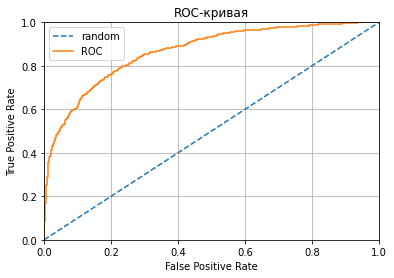

In [28]:
probabilities_valid = model_rf_ups.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', label="random")
plt.plot(fpr, tpr, label='ROC')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
plt.legend()
plt.show()

In [29]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8667293587351332


Взглянув на кривую и увидев площадь под кривой, можно понять, что наша модель получилась довольно высокого качества и сильно отличается от случайной в лучшую сторону. Кривая очень высокая, и визуально мне кажется, что можно поднять порог, чтобы еще больше повысить качество модели?  Давайте проверим эту гипоезу:

In [30]:
y_pred = (probabilities_one_valid >= 0.45).astype(bool)
print(classification_report(target_valid, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1991
           1       0.60      0.66      0.63       509

    accuracy                           0.84      2500
   macro avg       0.75      0.77      0.76      2500
weighted avg       0.85      0.84      0.84      2500



array([False, False,  True, ..., False,  True,  True])

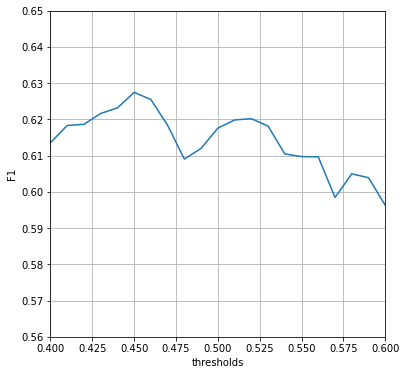

In [46]:
thresholds_array = np.arange(0.4, 0.61, 0.01)
f1_array = [f1_score(target_valid, (probabilities_one_valid >= i)) for i in thresholds_array]

plt.figure(figsize=(6, 6))
plt.plot(thresholds_array, f1_array)
plt.xlabel('thresholds')
plt.ylabel('F1')
plt.grid()
plt.xlim(0.4, 0.6)
plt.ylim(0.56, 0.65)
plt.show()

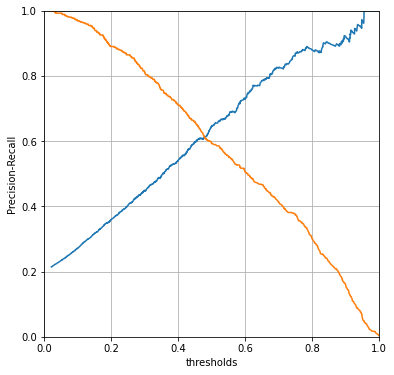

Best threshold = 0.48


In [31]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(thresholds, precision[:-1])
plt.xlabel('thresholds')
plt.ylabel('Precision-Recall')
plt.plot(thresholds, recall[:-1])
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f'Best threshold = {np.round(thresholds[np.argmin(np.abs(precision - recall))], 3)}')

А вот и еще один способ воысить качество модели на один пункт по f1. мы немного пожертвовали точностью, но еще сильнее увеличили полноту. Заказчик должен быть доволен. 

Теперь давайте перейдем к тестированию модели и проверим ее качество уже на тестовой выборке!

## Downsampling

In [32]:
features_train.shape

(7500, 10)

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1985)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1985)] + [target_ones])   
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1985)    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)
features_downsampled.shape

(3917, 10)

In [34]:
%%time
model_rf_down = None
best_result_down = 0
est_down = 0
depth_down = 0
for est in range(10, 51, 5):
    for depth in range(1,13):
        clf = RandomForestClassifier(random_state=1985, n_estimators=est, max_depth=depth)
        clf.fit(features_downsampled, target_downsampled)
        result = clf.score(features_valid, target_valid)
        if result > best_result_down:
            model_rf_down = clf
            best_result_down = result
            est_down = est
            depth_down = depth
print(best_result_down, est, depth_rf)
print(classification_report(target_valid, model_rf_down.predict(features_valid), target_names=['0', '1'])) 

0.8536 50 12
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1991
           1       0.67      0.55      0.60       509

    accuracy                           0.85      2500
   macro avg       0.78      0.74      0.76      2500
weighted avg       0.85      0.85      0.85      2500

CPU times: user 10.4 s, sys: 40 ms, total: 10.4 s
Wall time: 10.4 s


Наша модель получила удовлетворительный результат, который тем не менее ниже не только резултата модели, тренированной на увеличенной выборке, но и ниже результата модели, на которой мы не обращали внимание на дисбаланс классов. Тем не менее если сравнивать с моделью, где мы не учитывали дисбаланс классов, здесь recall по единице выше. 

Теперь, определившись с оптимальной моделью, давайте ее протестируем.

## Тестирование модели

In [35]:
print(classification_report(target_test,
                            model_rf_ups.predict(features_test), target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.66      0.58      0.62       407

    accuracy                           0.85      2000
   macro avg       0.78      0.75      0.77      2000
weighted avg       0.85      0.85      0.85      2000



Все показатели по единице очень низкие. F1= 0,33. Наша модель, видимо, невероятно переобучена. и у меня есть подозрение. Глубина у нас как правило 12, а это значит, что скорее всего в оценке учасвует id или порядковый номер. И тут рандом мог сильно повлиять на итоговую оценку. Давайте вернемся назад и удалим эти две колонки. 

UPD. Магия да и только. Мы избавились от порядковых номеров, ID и фамилий, однако глубина деревьев осталась прежней. Тем не менее качество моделей на тествой выборкке выросло прекраснейшим образом. У нас добавилось работы по идентификации клиентов, зато модель работает превосходно. Сейчас мы снова построим  ROC и посчитаем AUC ROC, а потом попробуем снова повысить качество модели при помощи порога. 

Text(0.5, 1.0, 'ROC-кривая')

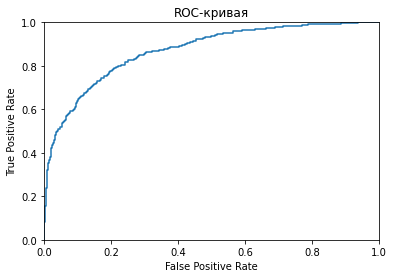

In [36]:
probabilities_test = model_rf_ups.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

In [37]:
auc_roc2 = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc2)

0.8700811751659209


кривая снова расположена очень высоко, а значение AUC ROC = 0,87. Это является хорошим показателем и свидетельствует о приемлемом качестве модели.

In [38]:
y_test = (probabilities_one_test >= 0.45).astype(bool)
print(classification_report(target_test, y_test, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1593
           1       0.61      0.65      0.63       407

    accuracy                           0.85      2000
   macro avg       0.76      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000



И снова, использовавав порог, мы получили более высокие показатели f1 и полноты. Думаю, что мы получили наилучшую модель таким образом. 


## Вывод

Была проведена большая работа по предобработке данных и построению моделей DT и RF. Модель RF  показала себя лучше. Для повышения точности пришлось применить масштабирование поработать с дисбалансом классов и установить пороги. Однако мы столкнулись с переобучением и чтобы избавиться от него пришлось избавиться от идентифицирующих клиента параметров, потому что, как ни странно, они сильно негативно отражались на качестве модели на тестовой выборке.

В результате нашей работы мы создали качественную модель, которая превосходит требования задачи на 4 пункта (f1=0.63, при требовании 0,59) и поможет банку спрогнозировать, кто из клиентов может уйти в ближайшее время, и снизить отток клиентов. 